In [1]:
import sys
sys.path.append('..')
from mp_api.client import MPRester
import numpy as np
from configs.silica import allegro
import tqdm
from matplotlib import pyplot as plt
from pymatgen.analysis.local_env import CrystalNN
import ase
from symphony.data import input_pipeline, input_pipeline_tf, fragments
from symphony import datatypes
import jax.random
import jax.numpy as jnp
import tensorflow as tf
import itertools
import ml_collections
import os
import yaml
import re

sys.path.append('../configs/silica/allegro.py')
import configs.silica.allegro as allegro

In [16]:
# query and download data
with MPRester("NA4RS6zGonPp3S3TQTSBPkzevjE3jAPt") as mpr:
    docs = mpr.materials.summary.search(elements=["Si", "O"], num_elements=(2, 2))

Retrieving SummaryDoc documents:   0%|          | 0/343 [00:00<?, ?it/s]

In [17]:
structures = [d.structure for d in docs]

In [4]:
from pymatgen.analysis.local_env import CrystalNN

In [18]:
for i in range(343):
    if str(docs[i].material_id) == "mp-600029":
        print(i)
        break

150


In [19]:
rec, send = input_pipeline.crystalnn(structures[150], (0.5, 1.0))
rec[send == 3]

/home/songk/anaconda3/envs/sh-net/lib/python3.10/site-packages/pymatgen/analysis/local_env.py:4135: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/home/songk/anaconda3/envs/sh-net/lib/python3.10/site-packages/pymatgen/analysis/local_env.py:3928: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(


array([43, 35, 38, 27])

In [32]:
cnn = CrystalNN()
cnn.get_nn_info(structures[0], 5)

[{'site': PeriodicNeighbor: O (4.573, 0.0, 0.0) [0.5, 0.0, 0.0],
  'image': (0, 0, 0),
  'weight': 1,
  'site_index': 8},
 {'site': PeriodicNeighbor: O (4.573, 0.0, 2.609) [0.5, 0.0, 0.5],
  'image': (0, 0, 0),
  'weight': 1,
  'site_index': 13},
 {'site': PeriodicNeighbor: O (5.883, 1.884, 1.304) [0.7622, 0.2378, 0.25],
  'image': (0, 0, 0),
  'weight': 1,
  'site_index': 6},
 {'site': PeriodicNeighbor: O (3.262, 1.884, 1.304) [0.4756, 0.2378, 0.25],
  'image': (0, 0, 0),
  'weight': 1,
  'site_index': 11}]

some statistics

In [15]:
num_atoms = []
num_neighbors_cutoff_3 = []
num_neighbors_cutoff_5 = []
min_distances = []
for item in tqdm.tqdm(docs):
    num_atoms.append(item.nsites)
    ct_25 = 0
    ct_3 = 0
    for i in range(num_atoms[-1]):
        min_dist = 1e10
        for j in range(i+1, num_atoms[-1]):
            dist = np.sqrt(np.sum((item.structure.cart_coords[i] - item.structure.cart_coords[j]) ** 2))
            min_dist = min(min_dist, dist)
            if dist < 5:
                ct_25 += 1
            if dist < 3:
                ct_3 += 1
        min_distances.append(min_dist)
    num_neighbors_cutoff_5.append(ct_25 / num_atoms[-1])
    num_neighbors_cutoff_3.append(ct_3 / num_atoms[-1])

num_atoms = np.asarray(num_atoms)
num_neighbors_cutoff_5 = np.asarray(num_neighbors_cutoff_5)
num_neighbors_cutoff_3 = np.asarray(num_neighbors_cutoff_3)
min_distances = np.asarray(min_distances)

100%|██████████| 343/343 [01:51<00:00,  3.08it/s]


In [5]:
np.average(num_atoms)

62.73837209302326

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0., 21573.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.]),
 array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
        -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45,  0.5 ]),
 <BarContainer object of 20 artists>)

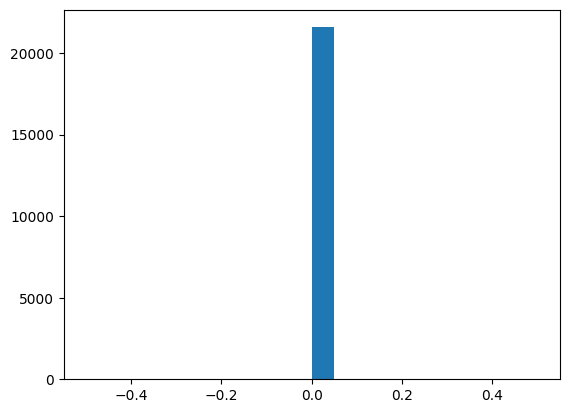

In [10]:
plt.hist(min_distances, bins=20)

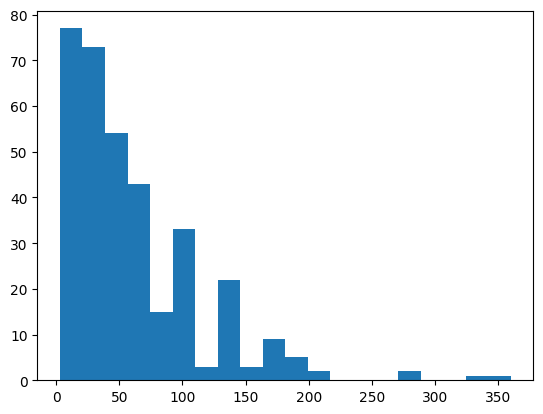

In [11]:
plt.hist(num_atoms, bins=20)
plt.show()

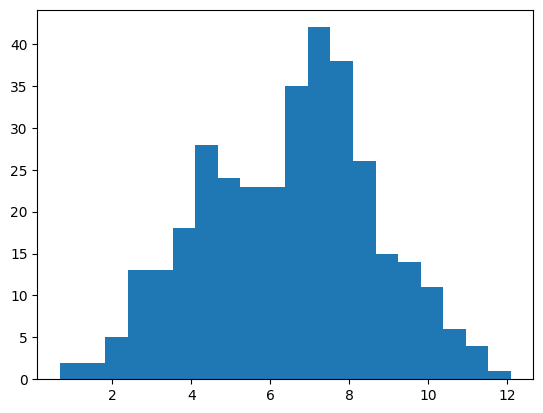

In [16]:
plt.hist(num_neighbors_cutoff_5, bins=20)
plt.show()

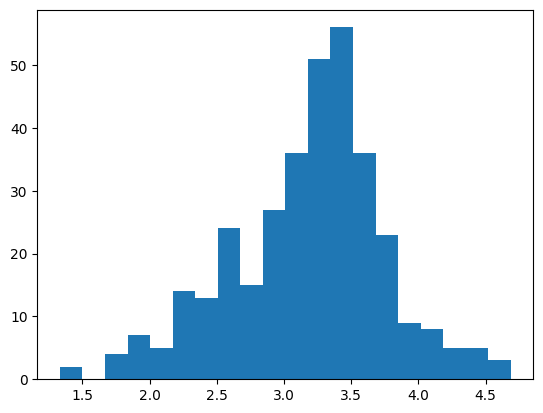

In [13]:
plt.hist(num_neighbors_cutoff_3, bins=20)
plt.show()

In [30]:
docs[5]

MPDataDoc<SummaryDoc>(
builder_meta=EmmetMeta(emmet_version='0.38.6', pymatgen_version='2022.10.22', pull_request=825, database_version='2022.10.28', build_date=datetime.datetime(2022, 10, 28, 0, 53, 47, 823000)),
nsites=144,
elements=[Element O, Element Si],
nelements=2,
composition=Comp: Si48 O96,
composition_reduced=Comp: Si1 O2,
formula_pretty='SiO2',
formula_anonymous='AB2',
chemsys='O-Si',
volume=2537.830345237013,
density=1.8870732340619993,
density_atomic=17.6238218419237,
symmetry=SymmetryData(crystal_system=<CrystalSystem.cubic: 'Cubic'>, symbol='Fm-3c', number=226, point_group='m-3m', symprec=0.1, version='1.16.2'),
property_name='summary',
material_id=MPID(mp-558931),
deprecated=False,
deprecation_reasons=None,
last_updated=datetime.datetime(2022, 10, 28, 0, 53, 47, 824000),
origins=[],
warnings=[],
structure=Structure Summary
Lattice
    abc : 15.31061119486541 15.31061119486541 15.31061119486541
 angles : 59.99999999999999 59.99999999999999 59.99999999999999
 volume : 253

structure matcher

In [4]:
from pymatgen.analysis.structure_matcher import StructureMatcher
from pymatgen.core import Structure
import os
import rdkit.Chem as Chem
from analyses import metrics

In [5]:
db_dir = "/home/songk/spherical-harmonic-net/conditional_generation/analysed_workdirs/test/silica-allegro-200k-train-steps-all-dec29/fait=1.0/pit=1.0/step=best/molecules/"
i = 4
molecules = []
with ase.db.connect(os.path.join(db_dir, f"generated_molecules_init=mol_{i}.db")) as db:
    for row in db.select():
        molecules.append(row.toatoms())

In [58]:
for i in range(len(molecules)):
    ase.io.write(f"example_out_{i}.xyz", molecules[i])

In [6]:
beta_species = 1.0
beta_position = 1.0
step = "best"
num_seeds_per_chunk = 1
max_num_atoms = 200  # ?
visualize = False
num_mols = 5
config = allegro.get_config()

molecules = input_pipeline_tf.get_raw_silica_datasets(config)
mols_by_split = {"train": [], "test": []}

# Root directory of the dataset.
filenames = sorted(os.listdir(config.root_dir))
filenames = [
    os.path.join(config.root_dir, f)
    for f in filenames
    if f.startswith("fragments_")
]
if len(filenames) == 0:
    raise ValueError(f"No files found in {config.root_dir}.")

# Partition the filenames into train, val, and test.
def filter_by_molecule_number(
    filenames, start: int, end: int
):
    def filter_file(filename: str, start: int, end: int) -> bool:
        filename = os.path.basename(filename)
        _, file_start, file_end = [int(val) for val in re.findall(r"\d+", filename)]
        return start <= file_start and file_end <= end

    return [f for f in filenames if filter_file(f, start, end)]

# Number of molecules for training can be smaller than the chunk size.
chunk_size = int(filenames[0].split("_")[-1])
train_on_split_smaller_than_chunk = config.get("train_on_split_smaller_than_chunk")
if train_on_split_smaller_than_chunk:
    train_molecules = (0, chunk_size)
else:
    train_molecules = config.train_molecules
files_by_split = {
    "train": filter_by_molecule_number(filenames, *train_molecules),
    "test": filter_by_molecule_number(filenames, *config.test_molecules),
}

element_spec = tf.data.Dataset.load(filenames[0]).element_spec
for split, files in files_by_split.items():
    dataset_split = tf.data.Dataset.from_tensor_slices(files)
    dataset_split = dataset_split.interleave(
        lambda x: tf.data.Dataset.load(x, element_spec=element_spec),
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )
    dataset_split = dataset_split.map(
        input_pipeline_tf._convert_to_graphstuple,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )
    mols_by_split[split] = list(dataset_split.as_numpy_iterator())

# mols_by_split['train'] = mols_by_split['train'][:num_mols]
# mols_by_split['test'] = mols_by_split['test'][-num_mols:]

Retrieving SummaryDoc documents:   0%|          | 0/343 [00:00<?, ?it/s]

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 14253332890173845436
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 14253332890173845436
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing 

In [20]:
ase_mols_by_split = {'train': [], 'test': []}
for split, mols in mols_by_split.items():
    for mol in mols:
        ase_mols_by_split[split].append(
            ase.Atoms(
                positions=mol.nodes.positions,
                numbers=get_atomic_numbers(
                    mol.nodes.species
                ),
                cell=np.squeeze(mol.globals.cell, axis=0),
                pbc=True
            )
        )
import pickle
with open('ase_mols_by_split.pkl', 'wb') as f:
    pickle.dump(ase_mols_by_split, f)

In [7]:
def ase_to_structure(mol):
    return Structure(mol.get_cell(), mol.get_atomic_numbers(), mol.get_positions())

def structure_to_ase(struct):
    return ase.Atoms(positions=struct.cart_coords, numbers=struct.atomic_numbers, cell=struct.lattice.matrix)

def ase_to_rdkit(mol):
    ase.io.write('/tmp/test.xyz', mol)
    return Chem.MolFromXYZFile("/tmp/test.xyz")

def graphstuple_to_ase(graph):
    return ase.Atoms(positions=graph.nodes.positions, numbers=np.vectorize(lambda x: 14 if x else 8)(graph.nodes.species))

In [53]:
for i in range(10):
    ase.io.write(f"example_{i}.xyz", graphstuple_to_ase(mols_by_split['train'][i]))

In [8]:
rdkit_mol = ase_to_rdkit(structure_to_ase(structures[0]))
metrics.get_posebusters_results([rdkit_mol])  # what's the steric clash check? is there a cutoff?

,,mol_pred_loaded,sanitization,all_atoms_connected,bond_lengths,bond_angles,internal_steric_clash,aromatic_ring_flatness,double_bond_flatness,internal_energy
file,molecule,,,,,,,,,
<rdkit.Chem.rdchem.Mol object at 0x7fea486a98c0>,mol_at_pos_0,True,True,False,True,True,False,True,True,False


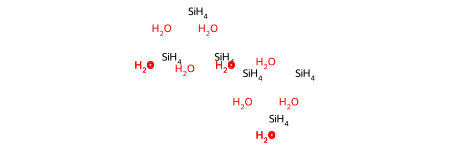

In [11]:
rdkit_mol

In [22]:
# CDVAE (https://arxiv.org/pdf/2110.06197.pdf) uses this for similarity to original structure
for struct in structures:
    if StructureMatcher().fit(ase_to_structure(ase.Atoms(symbols="CO2")), struct):
        print(struct)
        break

False